<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions


https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [42]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the files tab
1. Drag `punch.csv` and `flex.csv` files from your computer to the tab to upload them into colab.

# Graph Data (optional)

We'll graph the input files on two separate graphs, acceleration and gyroscope, as each data set has different units and scale.

<ipython-input-40-91e50062f3c0>:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-40-91e50062f3c0>:14: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-40-91e50062f3c0>:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')


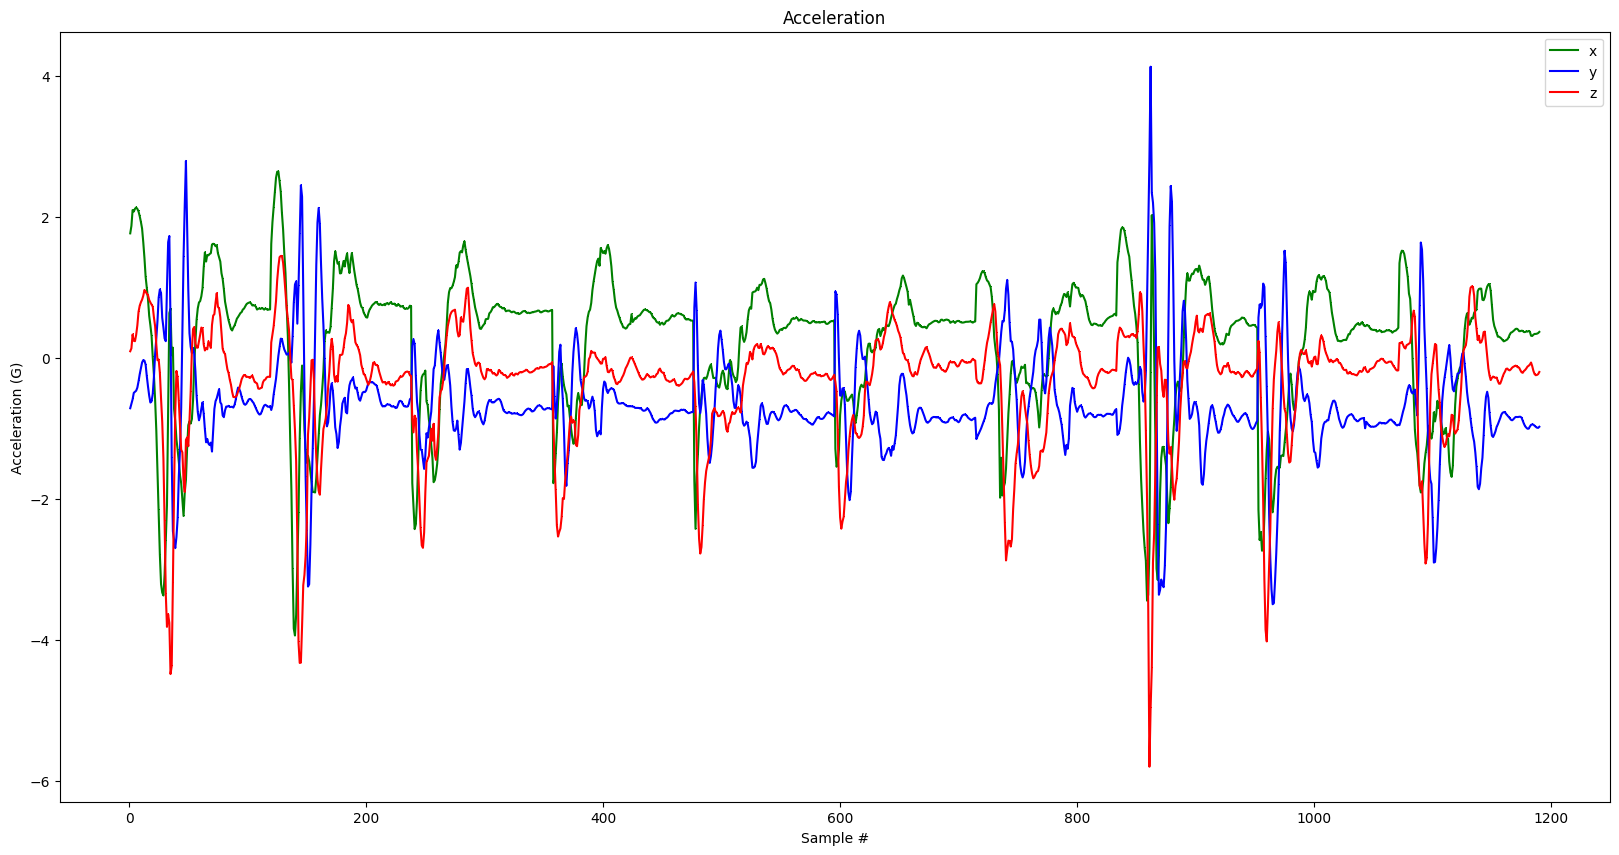

<ipython-input-40-91e50062f3c0>:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
<ipython-input-40-91e50062f3c0>:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "b." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
<ipython-input-40-91e50062f3c0>:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "r." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')


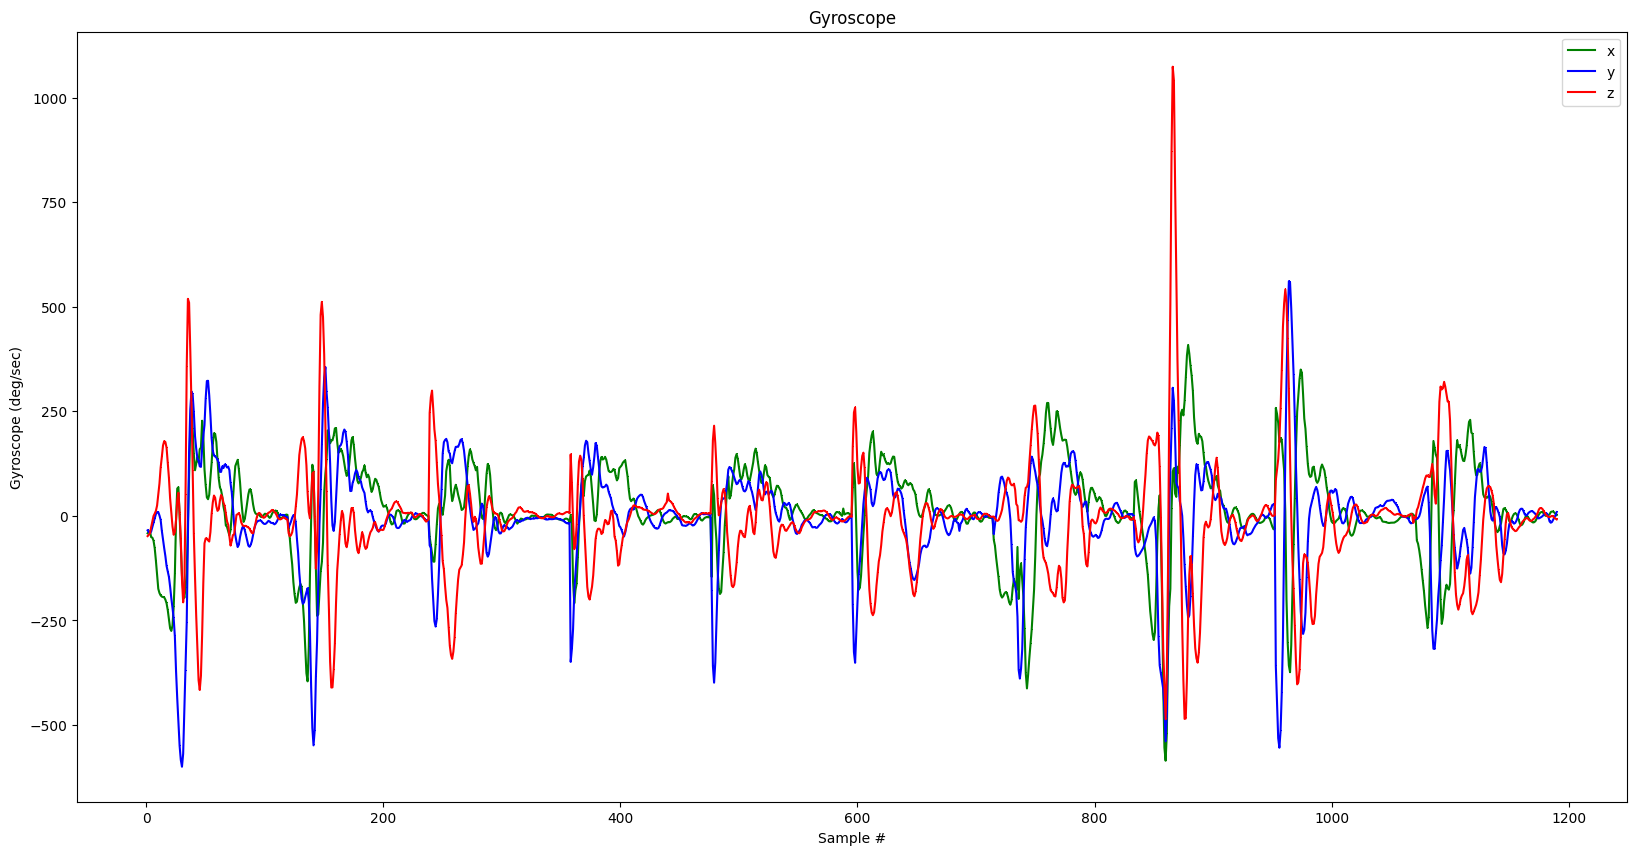

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "punch.csv"

df = pd.read_csv("/content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Gyroscope")
plt.xlabel("Sample #")
plt.ylabel("Gyroscope (deg/sec)")
plt.legend()
plt.show()


# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "punch",
    "flex",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")
import tensorflow as tf
import tensorflow_datasets as tfds

# 加载数据集
dataset_name = 'cifar10'
train_dataset, test_dataset = tfds.load(
    name=dataset_name,
    split=['train', 'test'],
    with_info=False,
    as_supervised=True,
    batch_size=-1
)

# 将数据集转换为 numpy 数组
train_data, train_labels = tfds.as_numpy(train_dataset[0]), tfds.as_numpy(train_dataset[1])
test_data, test_labels = tfds.as_numpy(test_dataset[0]), tfds.as_numpy(test_dataset[1])

# 定义验证集比例
validation_ratio = 0.1  # 例如，10% 的训练数据用作验证集

# 计算验证集的大小
validation_size = int(len(train_data) * validation_ratio)

# 划分训练集和验证集
validation_data = train_data[-validation_size:]
validation_labels = train_labels[-validation_size:]
train_data = train_data[:-validation_size]
train_labels = train_labels[:-validation_size]

# 打印样本数量
print(f"Train sample count: {len(train_data)}")
print(f"Validation sample count: {len(validation_data)}")
print(f"Test sample count: {len(test_data)}")

TensorFlow version = 2.18.0

Processing index 0 for gesture 'punch'.
	There are 10 recordings of the punch gesture.
Processing index 1 for gesture 'flex'.
	There are 15 recordings of the flex gesture.
Data set parsing and preparation complete.
Train sample count: 45000
Validation sample count: 5000
Test sample count: 10000


## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [51]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [44]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4023 - mae: 0.5548 - val_loss: 0.2287 - val_mae: 0.4779
Epoch 2/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3466 - mae: 0.5626 - val_loss: 0.2192 - val_mae: 0.4606
Epoch 3/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2828 - mae: 0.5112 - val_loss: 0.2137 - val_mae: 0.4569
Epoch 4/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2705 - mae: 0.5027 - val_loss: 0.2092 - val_mae: 0.4519
Epoch 5/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2635 - mae: 0.4939 - val_loss: 0.2030 - val_mae: 0.4435
Epoch 6/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2538 - mae: 0.4852 - val_loss: 0.1986 - val_mae: 0.4418
Epoch 7/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2452 - mae: 0.4807 - val_loss: 0.1944 - val_mae: 0.4390
Epoch 8/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2382 - mae: 0.4748 - val_loss: 0.1881 - val_mae: 0.4314
Epoch 9/600
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.23

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

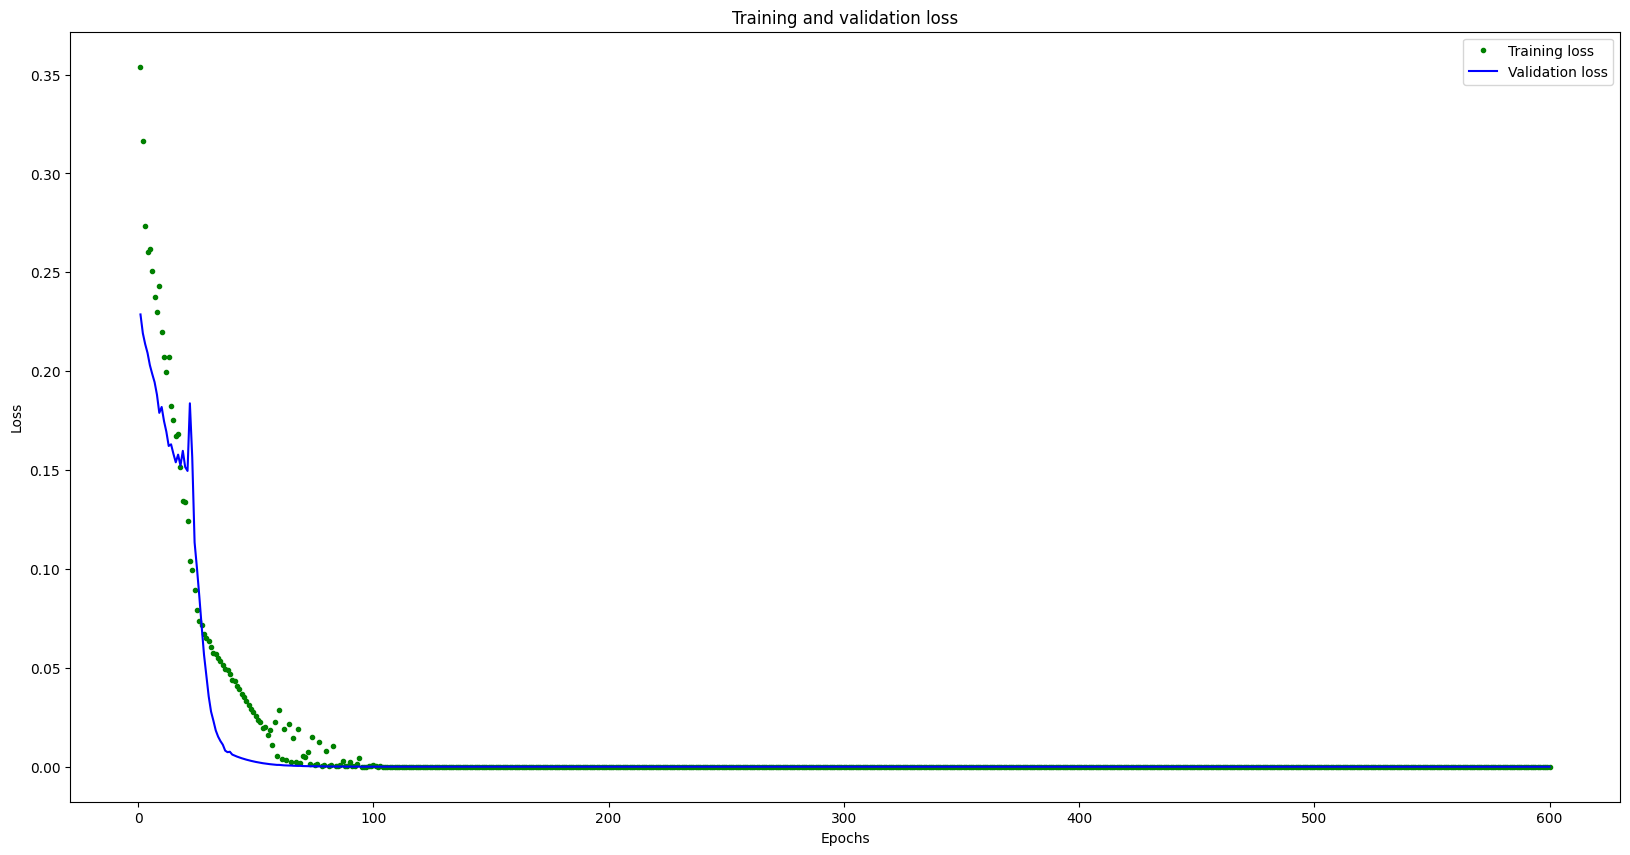

[20.0, 10.0]


In [74]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

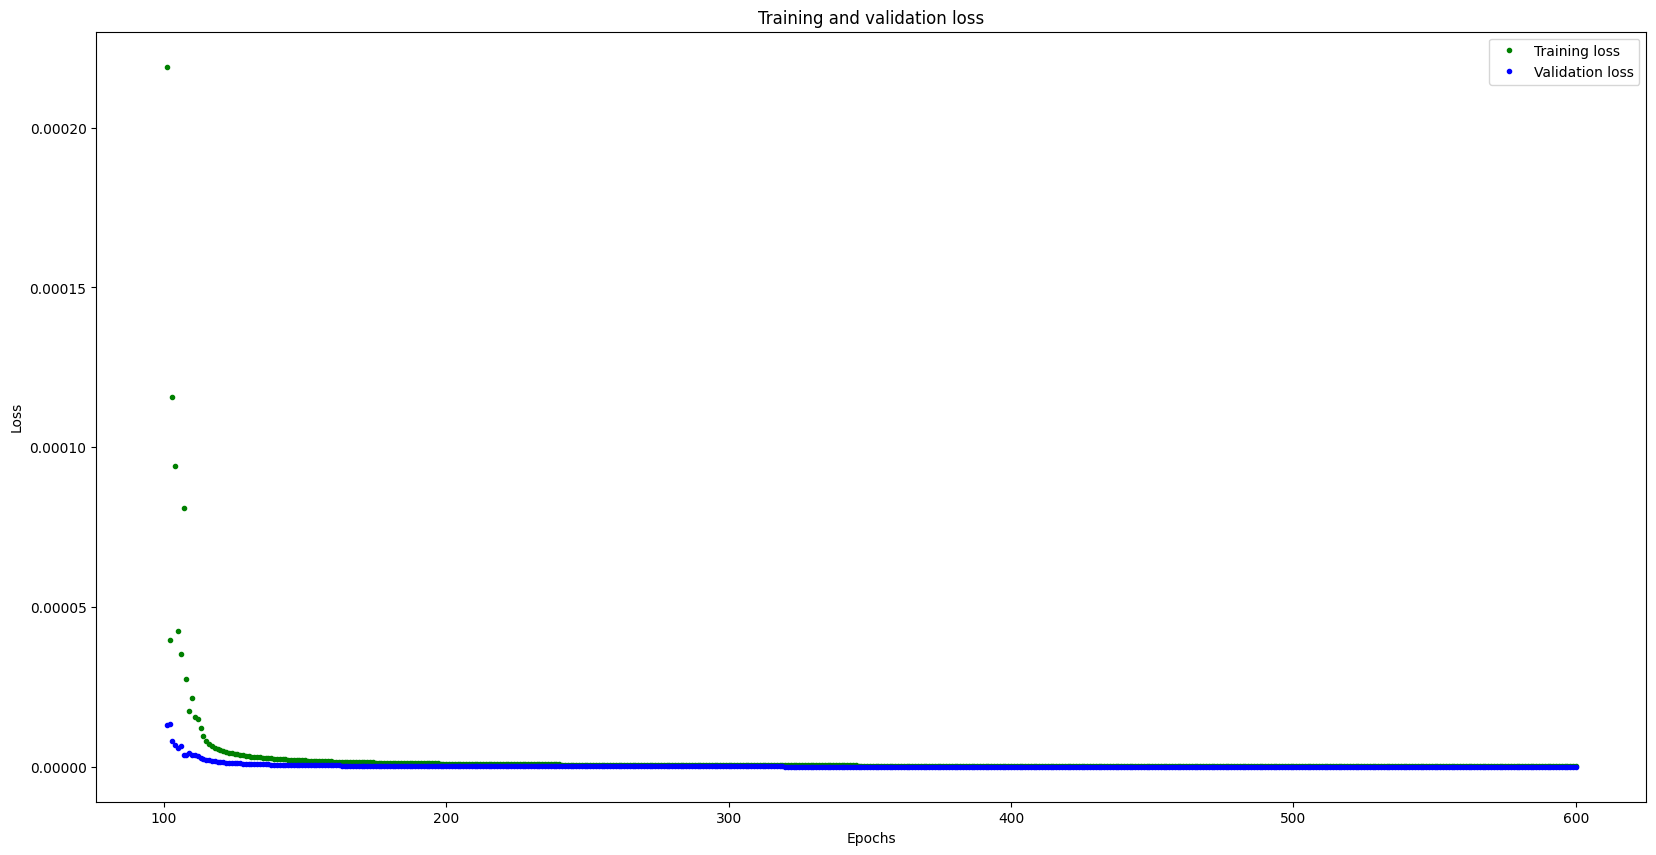

In [46]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



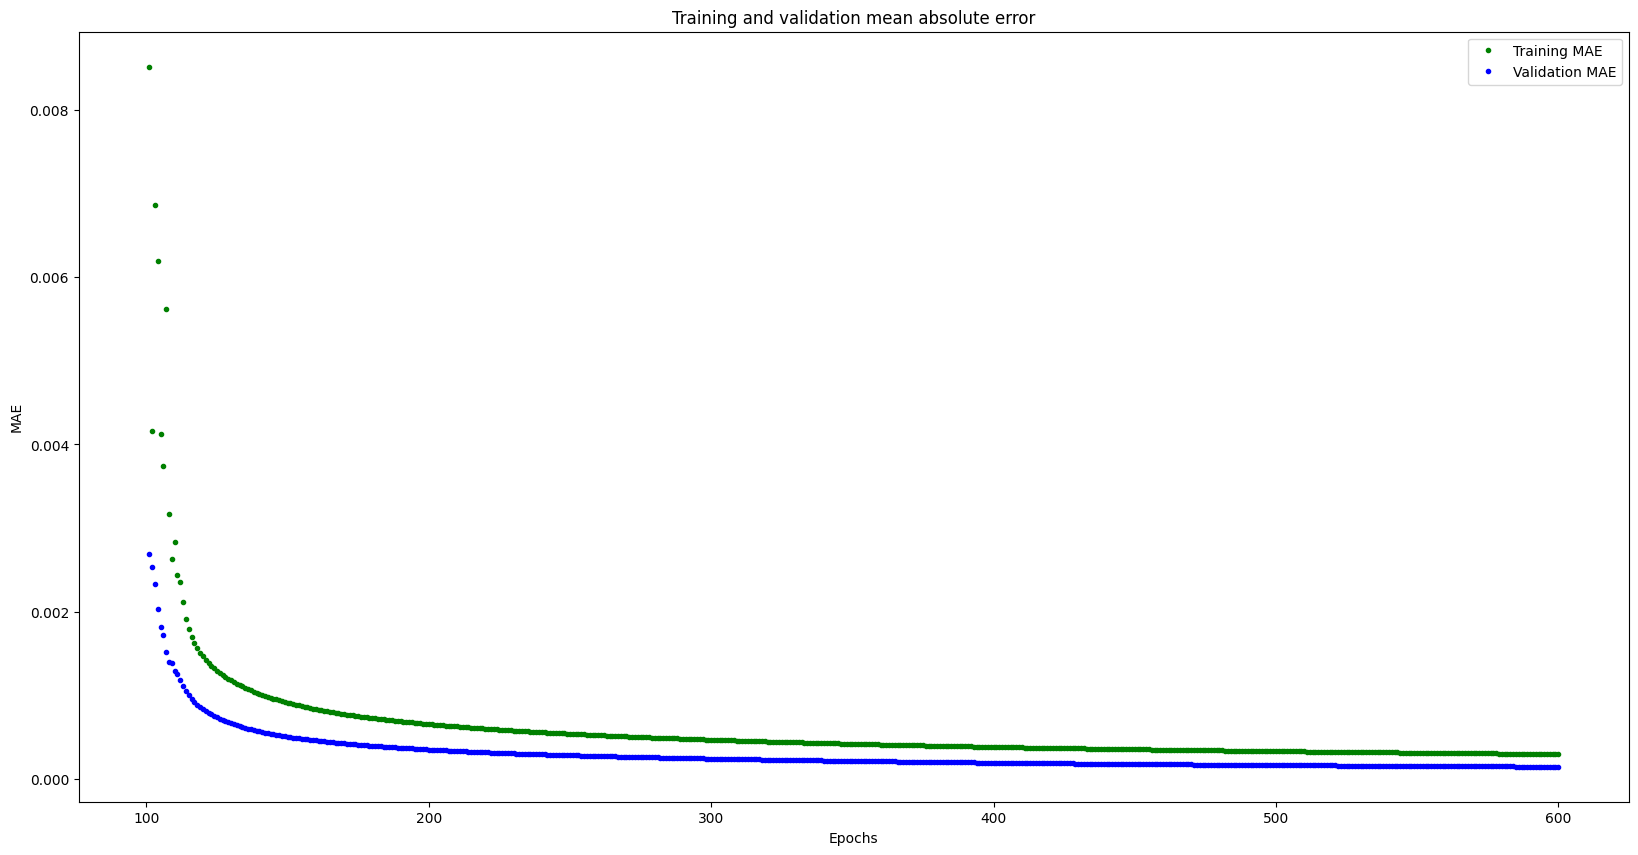

In [47]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with Test Data
Put our test data into the model and plot the predictions


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 39s 26ms/step - accuracy: 0.3117 - loss: 2.3703 - val_accuracy: 0.5284 - val_loss: 1.3183
Epoch 2/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.5152 - loss: 1.3544 - val_accuracy: 0.5688 - val_loss: 1.1923
Epoch 3/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 37s 25ms/step - accuracy: 0.5775 - loss: 1.1950 - val_accuracy: 0.5772 - val_loss: 1.2512
Epoch 4/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.6191 - loss: 1.0919 - val_accuracy: 0.6008 - val_loss: 1.1223
Epoch 5/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.6446 - loss: 1.0131 - val_accuracy: 0.6228 - val_loss: 1.0650
Epoch 6/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.6721 - loss: 0.9389 - val_accuracy: 0.6388 - val_loss: 1.0356
Epoch 7/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.6965 - loss: 0.8777 - val_accuracy: 0.6140 - val_loss: 1.1999
Epoch 8/10
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.7052 -

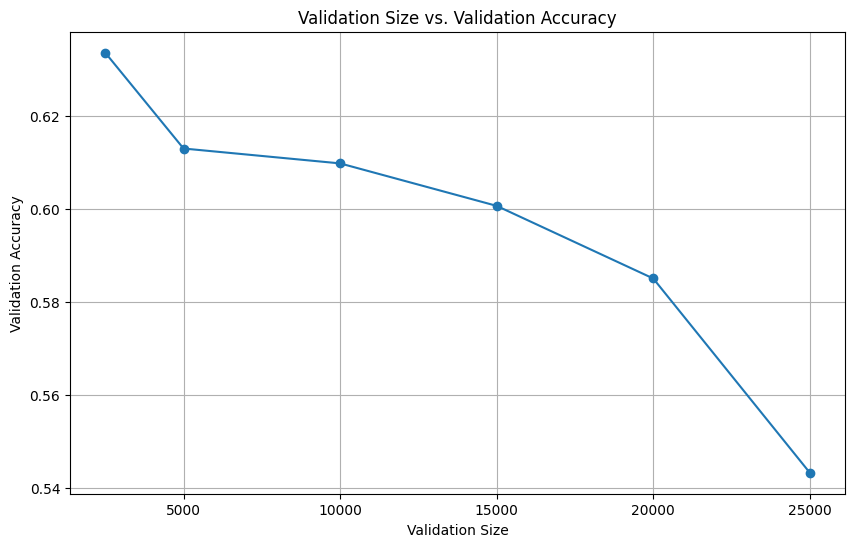

In [39]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [48]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)



Saved artifact at '/tmp/tmprp5f8nj7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 714), dtype=tf.float32, name='keras_tensor_58')
Output Type:
  TensorSpec(shape=(1, 2), dtype=tf.float32, name=None)
Captures:
  137468703977168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468703978320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468703976976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468703978896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468703978704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137468703979664: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model is 148204 bytes


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [66]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import tensorflow as tf

# 假设你已经定义好的模型

# 获取优化方法的名称
optimizer_name = model.optimizer.__class__.__name__
learning_rate=model.optimizer.learning_rate
# 获取损失函数的名称
loss_name = model.loss

# 打印优化方法和损失函数的名称
print(f"Name of the Optimization Method: {optimizer_name}")
print(f"Loss Function Name: {loss_name}")
print(f"Learning rate: {learning_rate.numpy()}")
epochs = len(history.history['loss'])

# 打印 epochs 数量
print(f"Number of Epochs: {epochs}")
print(f"loss: {training loss}")

SyntaxError: f-string: invalid syntax. Perhaps you forgot a comma? (<ipython-input-66-3f81be1d987a>, line 23)

# Classifying IMU Data

Now it's time to switch back to the tutorial instructions and run our new model on the Arduino Nano 33 BLE Sense to classify the accelerometer and gyroscope data.
